# Matrix Profile

## Introduction

The Matrix Profile is a methodology that systematically calculates the shortest Euclidian distances for all segments of a given window size across the whole time-series. The calculations allow to identify where the closest pattern is located as well as spot the patterns that have the largest difference with all other patterns. Using the matrix profile, it is also possible to detect regime changes (FLUSS/FLOSS algorithms).

This notebook explores the ideas of the Matrix Profile with and tests them out on both simulated data and real data.

## Setup

In [1]:
import pandas as pd
import numpy as np
import stumpy
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [2]:
sns.set(rc={"figure.figsize": (20, 10)})

## Simulated data

### Sinusoidal data

In [38]:
divs = 10
x = np.arange(start=-4 * np.pi, stop=4 * np.pi, step=np.pi/divs)
y = np.sin(x)
mp = stumpy.stump(y, m=divs)

A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


In [39]:
mp[0:10]

array([[1.7631291696726132e-07, 40, -1, 40],
       [1.6323404237781945e-07, 41, -1, 41],
       [1.3328003749250113e-07, 42, -1, 42],
       [0.0, 43, -1, 43],
       [0.0, 44, 0, 44],
       [0.0, 25, 1, 25],
       [0.0, 26, 2, 26],
       [0.0, 27, 3, 27],
       [0.0, 48, 4, 48],
       [0.0, 29, 5, 29]], dtype=object)

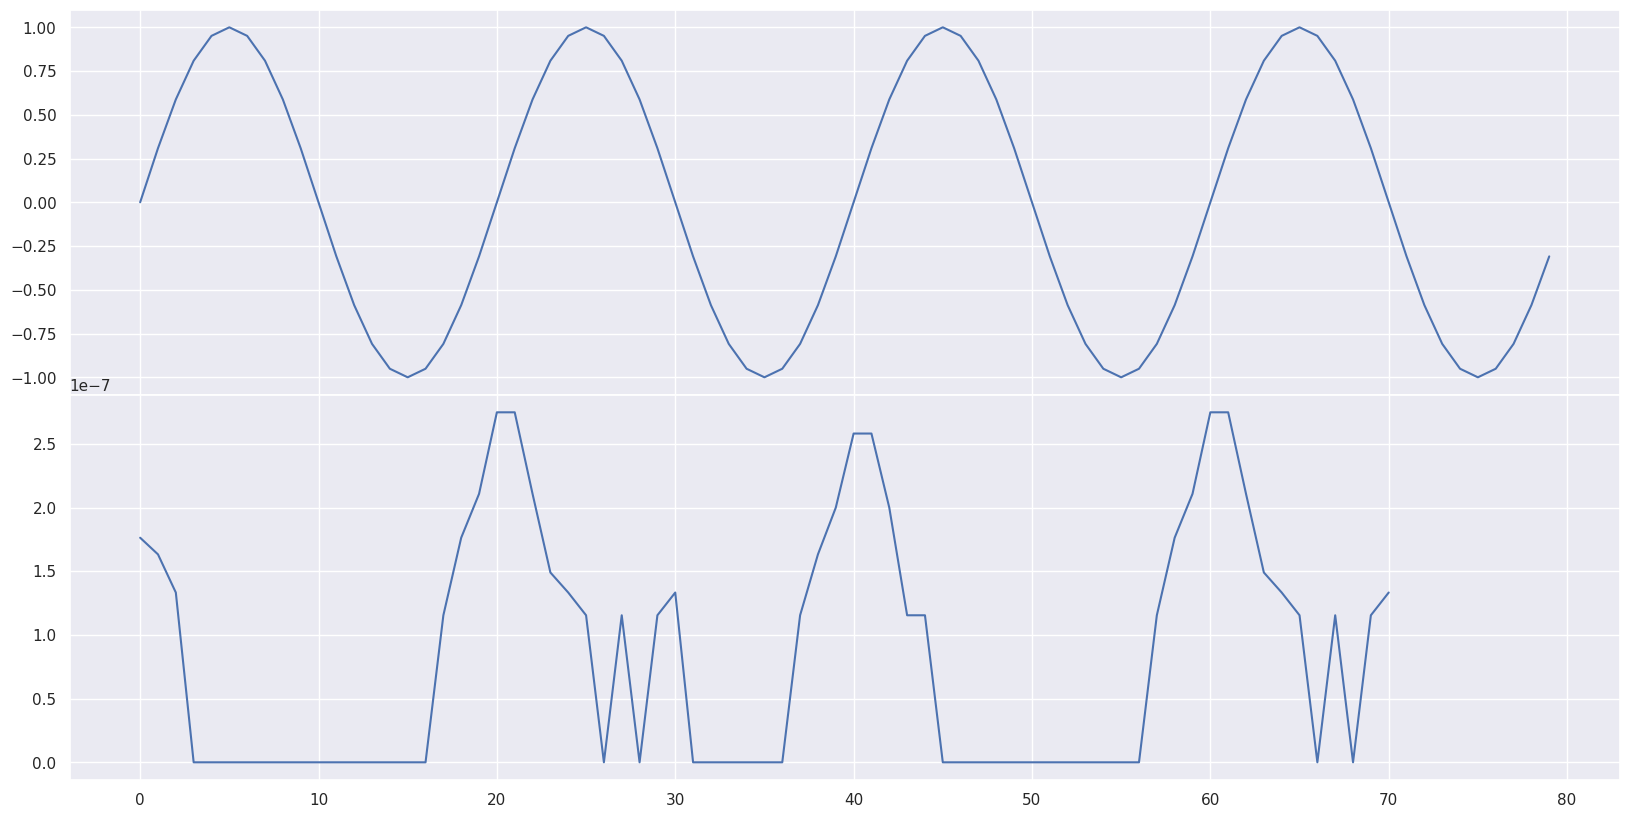

In [41]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(y)
#axs[0].set_ylabel('Steam Flow', fontsize='20')
#rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#axs[1].set_xlabel('Time', fontsize ='20')
#axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=motif_idx, linestyle="dashed")
#axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
#axs[1].set_ylim([0, 000000.1])
plt.show()

In [6]:
divs = 20
x = np.arange(start=-4 * np.pi, stop=4 * np.pi, step=np.pi/divs)
ys = np.sin(x)
e = np.concatenate([np.zeros(int(x.shape[0]/2)), 
                    np.random.normal(loc=0.0, scale=0.1, size=x.shape[0]-int(x.shape[0]/2))])
y = ys + e
mp = stumpy.stump(y, m=divs)

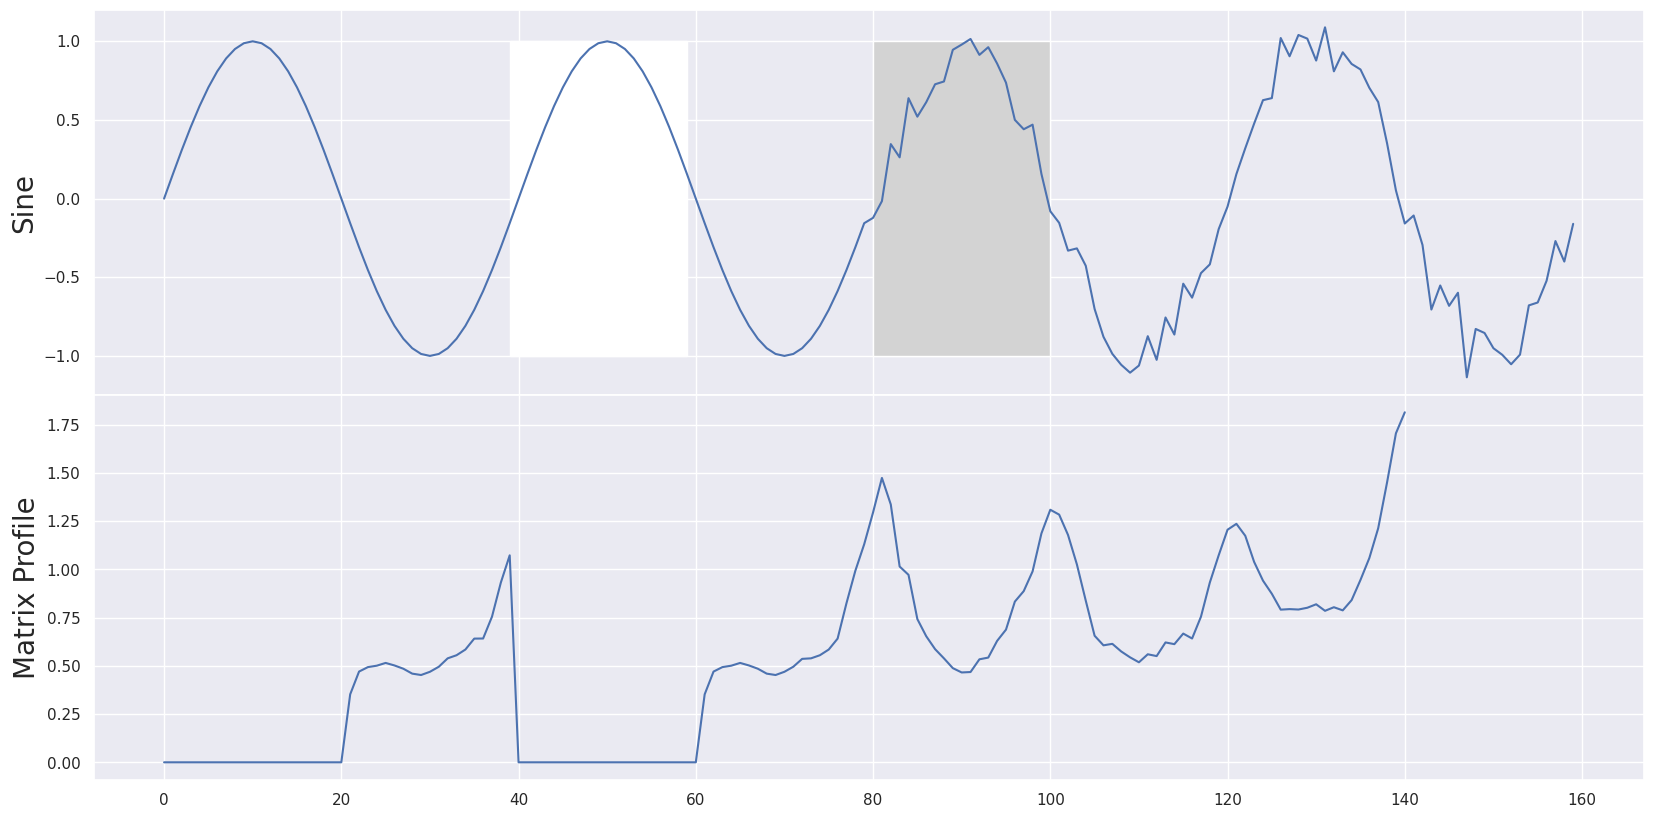

In [7]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(y)
axs[0].set_ylabel('Sine', fontsize='20')
rect = Rectangle((80, -1), divs, 2, facecolor='lightgrey')
axs[0].add_patch(rect)

rect = Rectangle((mp[80,1], -1), divs, 2, facecolor='white')
axs[0].add_patch(rect)

axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp[:, 0])
plt.show()


The reason we see the waves is that the distance is the z-scored Euclidian distance and not the straight Euclidian distance. The normalization when the curve is all positive (or negative) is going to subtract a mean that is positive (or negative, respectively), which will lower the overall values. In a seasonal setting like the one above, the issue will appear if the period length is misspecified. See also [Implications of Z-Normalization in the Matrix Profile, De Paepe et al. 2019](https://core.ac.uk/download/pdf/287941767.pdf).

Below we can see the z-scored Euclidian distance in action; we calculate it at the peak of 80 and the bottom of 90.

In [8]:
mp[80]

array([1.295943625844803, 39, 39, 119], dtype=object)

In [9]:
from scipy import stats
y1 = stats.zscore(y)
np.sqrt(np.sum((stats.zscore(y[80:100]) - stats.zscore(y[0:20]))**2))

1.4716042062002965

In [10]:
mp[90]

array([0.46598018086541837, 49, 49, 130], dtype=object)

In [11]:
np.sqrt(np.sum((stats.zscore(y[90:110]) - stats.zscore(y[10:30]))**2))

0.48890137688347257

### Non-seasonal

In [12]:
def generate_data(period_lengths, means, variances):
    res = pd.DataFrame()
    for l, mu, sigma in zip(period_lengths, means, variances):
        period = pd.DataFrame({'name': [f'({mu},{sigma})'] * l, 
                               'y': np.random.normal(loc=mu, scale=sigma, size=l)})
        res = pd.concat([res, period])
    return res

In [13]:
data = generate_data([100,200,150], [1, 7, 4], [1, 1, 1])
data

,name,y
0,"(1,1)",0.859847
1,"(1,1)",0.292135
2,"(1,1)",-0.187351
3,"(1,1)",1.315934
4,"(1,1)",0.472179
...,...,...
145,"(4,1)",4.596960
146,"(4,1)",4.464647
147,"(4,1)",2.942156
148,"(4,1)",4.088603


In [14]:
mp = stumpy.stump(data.y, m=25)

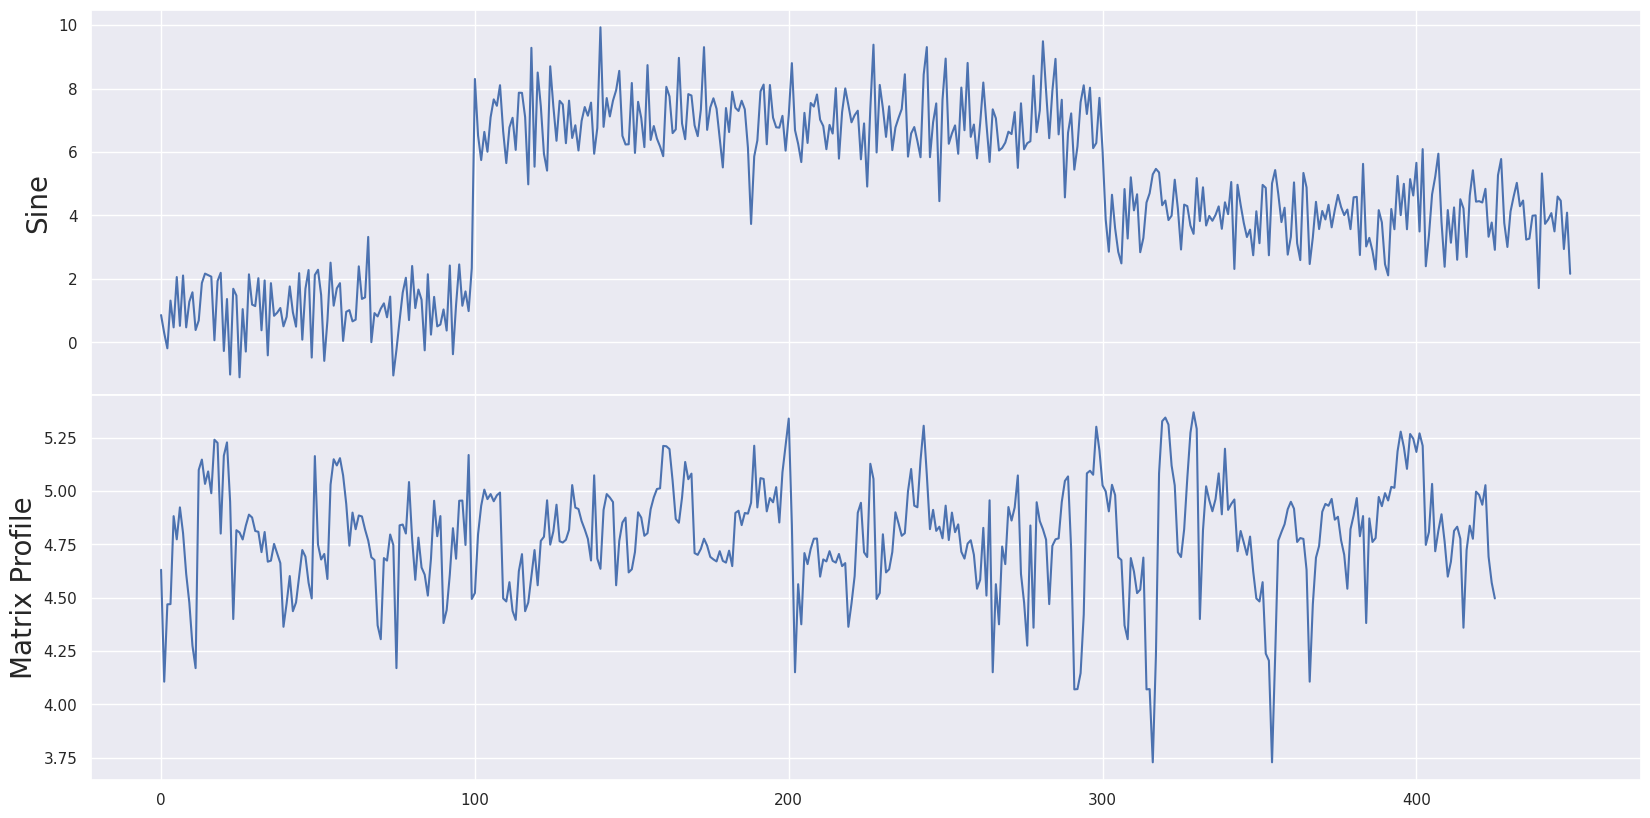

In [15]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(data.y.values)
axs[0].set_ylabel('Sine', fontsize='20')
#rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=motif_idx, linestyle="dashed")
#axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()


Note that because we have a history at a higher level, that period in itself does not have larger matrix profile values. That is the case because our window is much smaller than the anomaly period, and hence close sequences can be found within the period. This shows that the window much be chosen carefully, and that long mean or variance deviations will not immediately appear in the matrix profile (see later FLUSS for a regime change algorithm based on the matrix profile).

# Real data example - counts of death and select causes

## A view of the data

The [Weekly Counts of Death by Jurisdiction and Select Causes of Death](https://catalog.data.gov/dataset/weekly-counts-of-death-by-jurisdiction-and-cause-of-death) is a government data set that aggregates select causes of death from the various states. Likely to preserve the continuity with previous statistics, it does not list COVID-19 as a cause of death, but the prevalent accompanying comorbidity.

At any rate, we use the total count anyway, and try to see if using the matrix profile we can spot anomalies or  regime changes in the mortality that could be due to COVID-19.

In [16]:
wc = pd.read_csv("~/Downloads/Weekly_Counts_of_Death_by_Jurisdiction_and_Select_Causes_of_Death(1).csv")
wc['Week Ending Date'] = wc['Week Ending Date'].astype('datetime64[ns]')

In [17]:
wc

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
2,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
4,Alabama,2017-01-07,AL,2017,1,Alzheimer disease and dementia,96,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436527,Wisconsin,2018-12-29,WI,2018,52,Respiratory diseases,27,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Unweighted
436528,Wisconsin,2019-12-28,WI,2019,52,Respiratory diseases,23,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)
436529,Wisconsin,2019-12-28,WI,2019,52,Respiratory diseases,23,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Unweighted
436530,Wisconsin,2021-01-02,WI,2020,53,Respiratory diseases,15,Other diseases of the respiratory system,2020,NaN,Data in recent weeks are incomplete. Only 60% ...,15,-4.0,-16.7,Predicted (weighted)


In [18]:
wc['Cause Group'].unique()

array(['Alzheimer disease and dementia', 'Circulatory diseases',
       'Malignant neoplasms', 'Other select causes',
       'Respiratory diseases'], dtype=object)

In [19]:
wc_group = wc[wc.Type=="Unweighted"].groupby(
    ['Year', 'Week Ending Date', 'Cause Group']
).agg({'Number of Deaths' : 'sum'}).reset_index()

In [20]:
wc_circ = wc_group[(wc_group['Cause Group'] =="Circulatory diseases")]
wc_resp = wc_group[(wc_group['Cause Group'] =="Respiratory diseases")]

In [21]:
wc_circ

,Year,Week Ending Date,Cause Group,Number of Deaths
1,2015,2015-01-10,Circulatory diseases,38866
6,2015,2015-01-17,Circulatory diseases,38081
11,2015,2015-01-24,Circulatory diseases,36395
16,2015,2015-01-31,Circulatory diseases,35525
21,2015,2015-02-07,Circulatory diseases,36280
...,...,...,...,...
2036,2022,2022-10-29,Circulatory diseases,33007
2041,2022,2022-11-05,Circulatory diseases,32065
2046,2022,2022-11-12,Circulatory diseases,30538
2051,2022,2022-11-19,Circulatory diseases,27730


<AxesSubplot: xlabel='Week Ending Date', ylabel='Number of Deaths'>

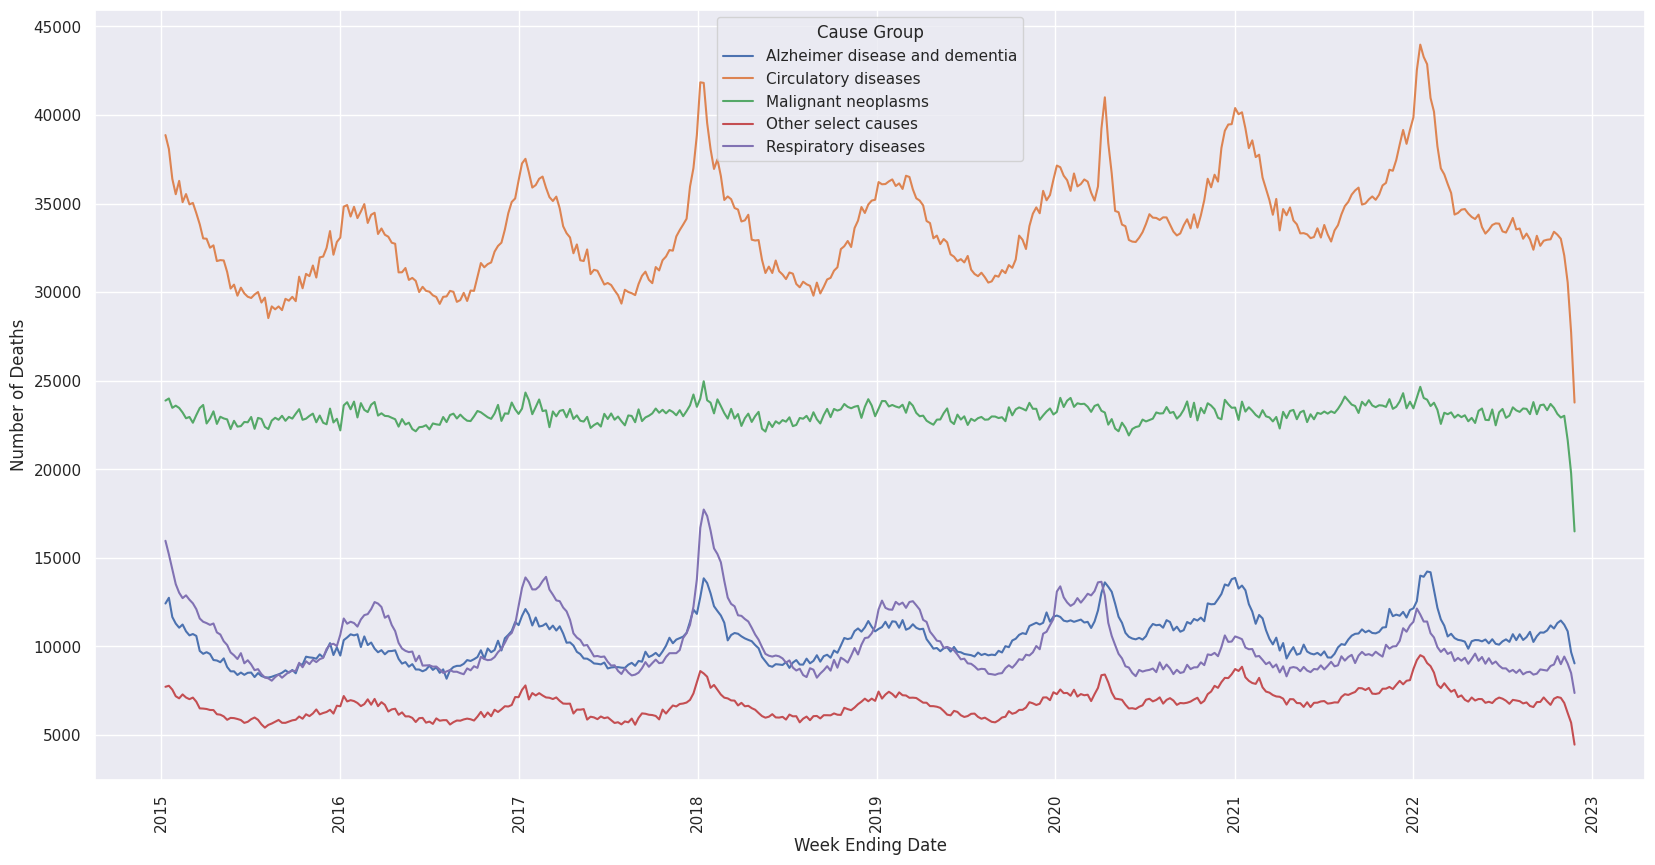

In [22]:
plt.xticks(rotation=90)
sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_group, hue='Cause Group')

<AxesSubplot: title={'center': 'All causes'}, xlabel='Week Ending Date', ylabel='Number of Deaths'>

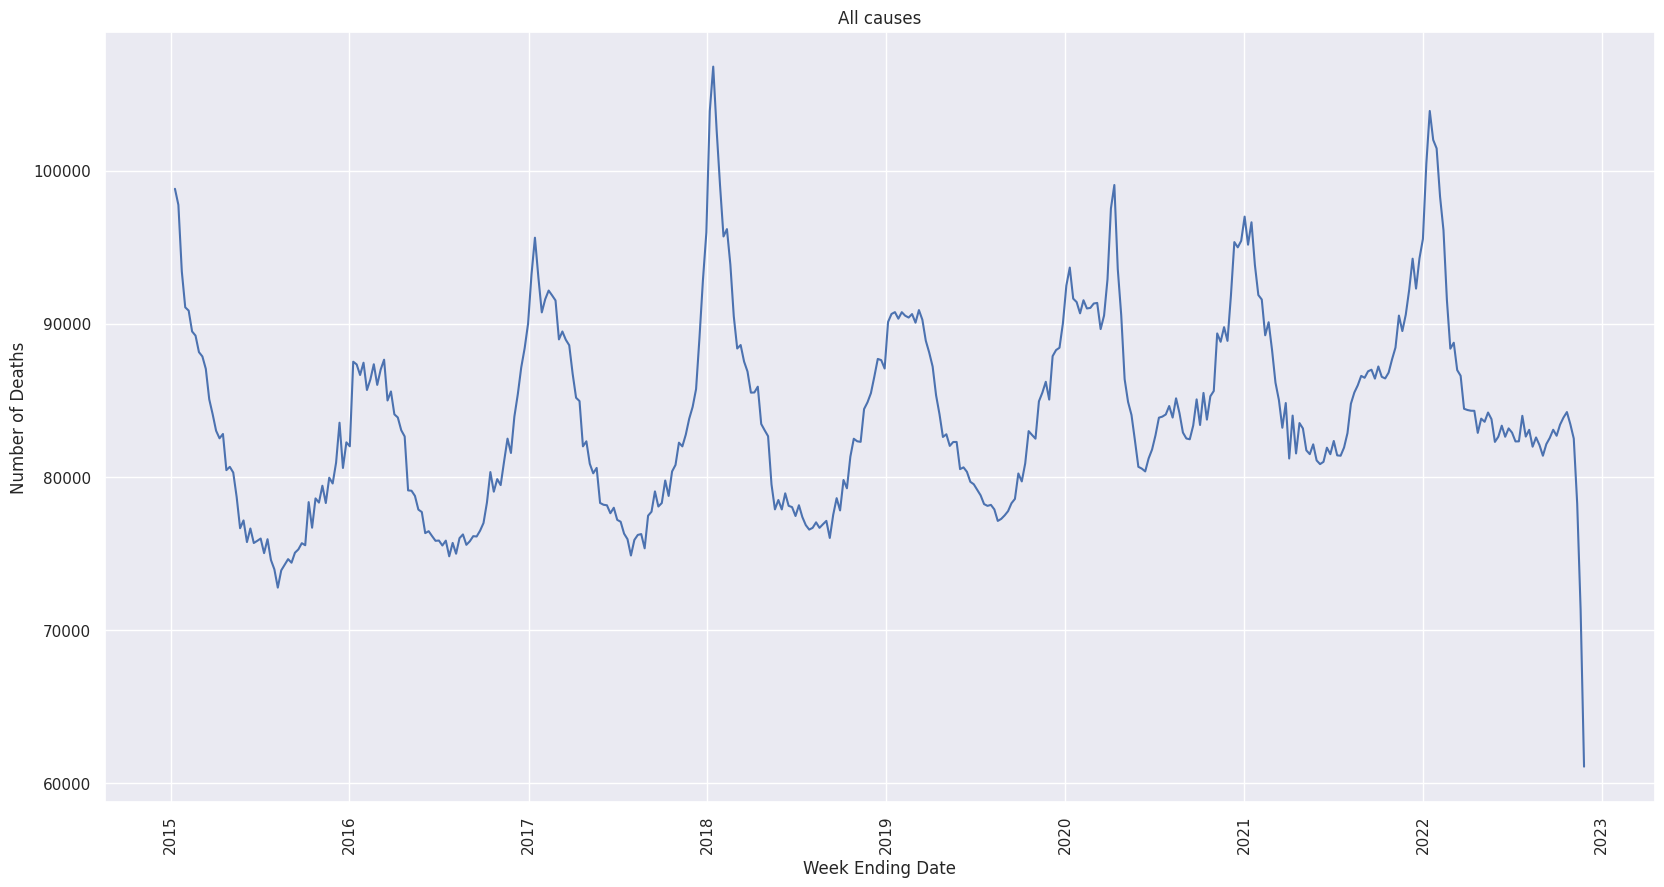

In [23]:
wc_all = wc[wc.Type=="Unweighted"].groupby(
    ['Year', 'Week Ending Date']
).agg({'Number of Deaths' : 'sum'}).reset_index()
plt.xticks(rotation=90)
plt.title('All causes')
sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all)

In [24]:
wc_all = wc_all[wc_all['Week Ending Date'] < '2022-11-01'].copy()
wc_all

,Year,Week Ending Date,Number of Deaths
0,2015,2015-01-10,98809
1,2015,2015-01-17,97758
2,2015,2015-01-24,93409
3,2015,2015-01-31,91069
4,2015,2015-02-07,90854
...,...,...,...
403,2022,2022-10-01,82682
404,2022,2022-10-08,83405
405,2022,2022-10-15,83870
406,2022,2022-10-22,84230


## Matrix profile

In [25]:
window_size = 52
wc_all['Number of Deaths'] = wc_all['Number of Deaths'].astype('float64')
matrix_profile = stumpy.stump(wc_all['Number of Deaths'], m=window_size)

In [26]:
matrix_profile_df = pd.DataFrame(matrix_profile)
matrix_profile_df['Week Ending Date'] = wc_all.loc[0:(matrix_profile_df.shape[0]+1), 'Week Ending Date']
matrix_profile_df

,0,1,2,3,Week Ending Date
0,1.484464,156,-1,156,2015-01-10
1,1.59334,157,-1,157,2015-01-17
2,1.729827,158,-1,158,2015-01-24
3,1.732635,159,-1,159,2015-01-31
4,1.714939,160,-1,160,2015-02-07
...,...,...,...,...,...
352,3.021723,144,144,-1,2021-10-09
353,2.967375,145,145,-1,2021-10-16
354,2.950722,145,145,-1,2021-10-23
355,2.923935,146,146,-1,2021-10-30


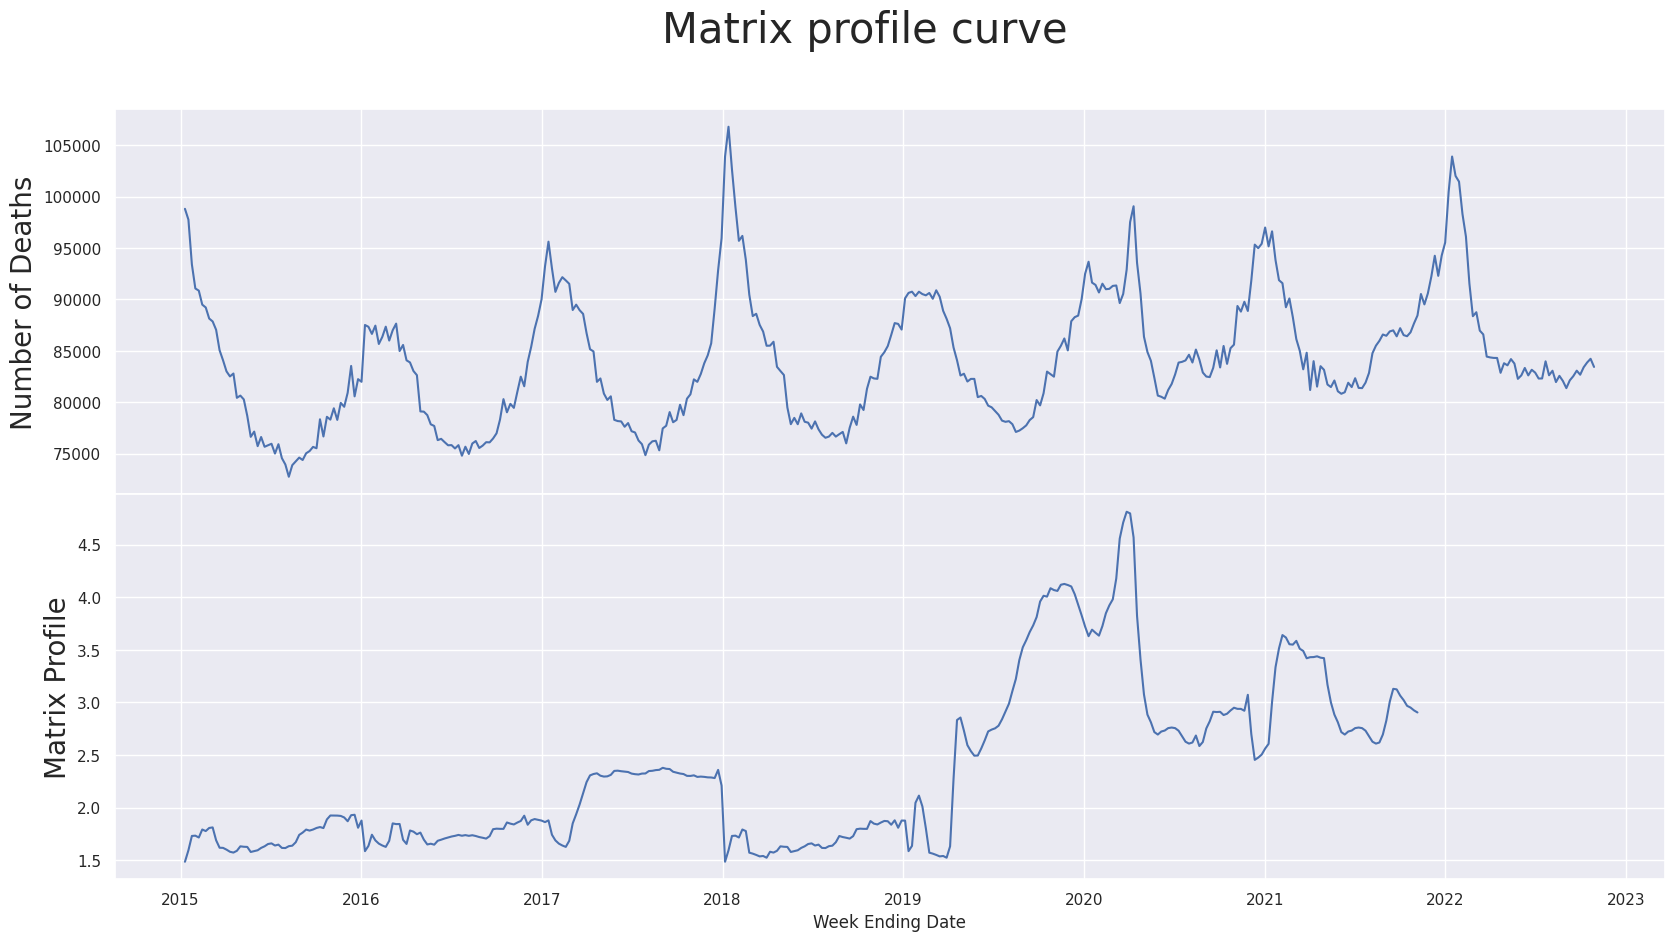

In [27]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Matrix profile curve', fontsize='30')

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
axs[0].set_ylabel('Number of Deaths', fontsize='20')

sns.lineplot(x='Week Ending Date', y=0, data=matrix_profile_df, ax=axs[1])
axs[1].set_ylabel('Matrix Profile', fontsize='20')
plt.show()

## Discord

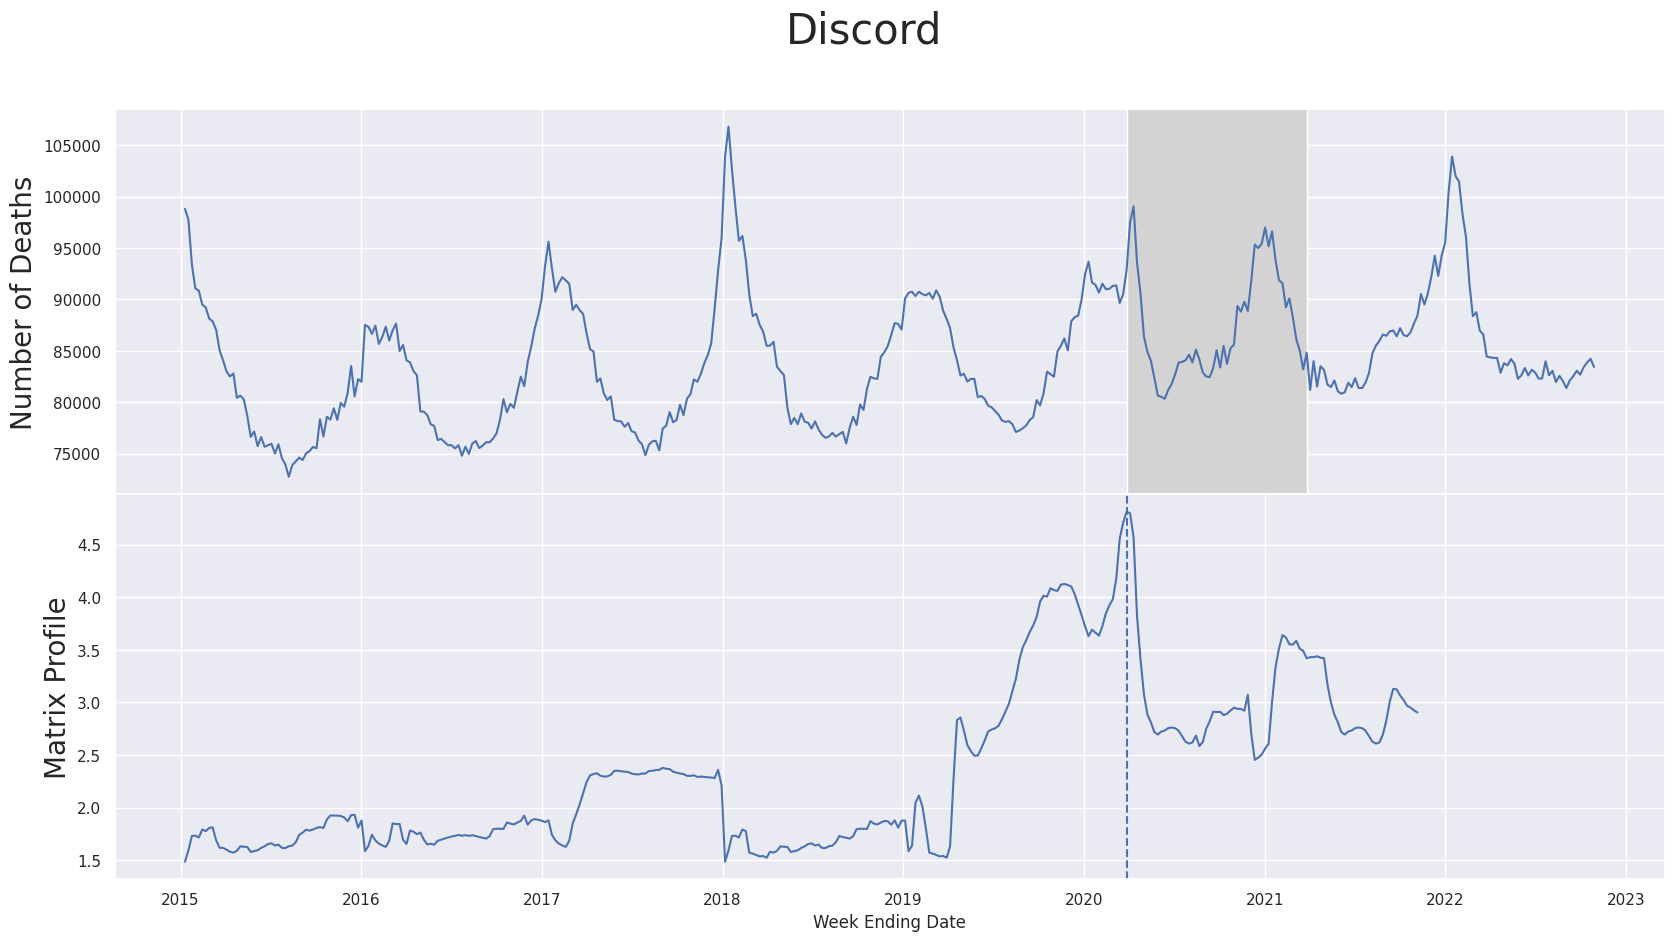

In [28]:
# take the last entry which will be the most different (highest value) segment of our window size
motif_idx = np.argsort(matrix_profile[:, 0])[-1]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord', fontsize='30')

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
axs[0].set_ylabel('Number of Deaths', fontsize='20')

s = mdates.date2num(matrix_profile_df['Week Ending Date'].values[motif_idx])
e = mdates.date2num(matrix_profile_df['Week Ending Date'].values[motif_idx + window_size])
rect = Rectangle((s, 0), e-s, 400000, facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].axvline(x=s, linestyle="dashed")
sns.lineplot(x='Week Ending Date', y=0, data=matrix_profile_df, ax=axs[1])
axs[1].set_ylabel('Matrix Profile', fontsize='20')
plt.show()

# FLUSS

FLUSS stands for Fast Low-cost Unipotent Semantic Segmentation and is a method based on the matrix profile to find regime changes in time-series data.

The idea is to count the number of arcs crossings a each point in the time-series. An arc crossing means that a point behind (respectively ahead) has its minimum distance ahead (respectively behind). The intuition is that a regime change would show up as a point with less arcs crossings, because the similarities will tend to be clustered.

Because as points get to the edge on each side of the time-series have lower possibilities of arc crossings, the count has to be adjusted.

## Calculations

In [29]:
cac, regime_locations = stumpy.fluss(matrix_profile[:, 1], L=window_size, n_regimes=2, excl_factor=1)

In [30]:
cac

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Below we take a look at the actual calculation by the `cac` function and try to understand how it is calculated and reproduce it:

In [31]:
from stumpy.floss import _nnmark, _iac

# compute the nearest neighbor nb of crossings, aka "arc crossings"
ac = _nnmark(matrix_profile[:, 1])

# ideal arc crossings:
iac = _iac(ac.shape[0])
iac[iac == 0.0] = 10**-10  # avoid divide by 0

# naively we get a super high value at the beginning, so this doesn't work:
cac1 = ac / iac

# this looks much better:
cac2 = cac1.copy()
cac2[cac2 > 1.0] = 1.0

# this is how the fluss function does it:
cac3 = cac2.copy()
cac3[: window_size * 1] = 1.0
cac3[-window_size * 1 :] = 1.0

Text(0, 0.5, 'cac')

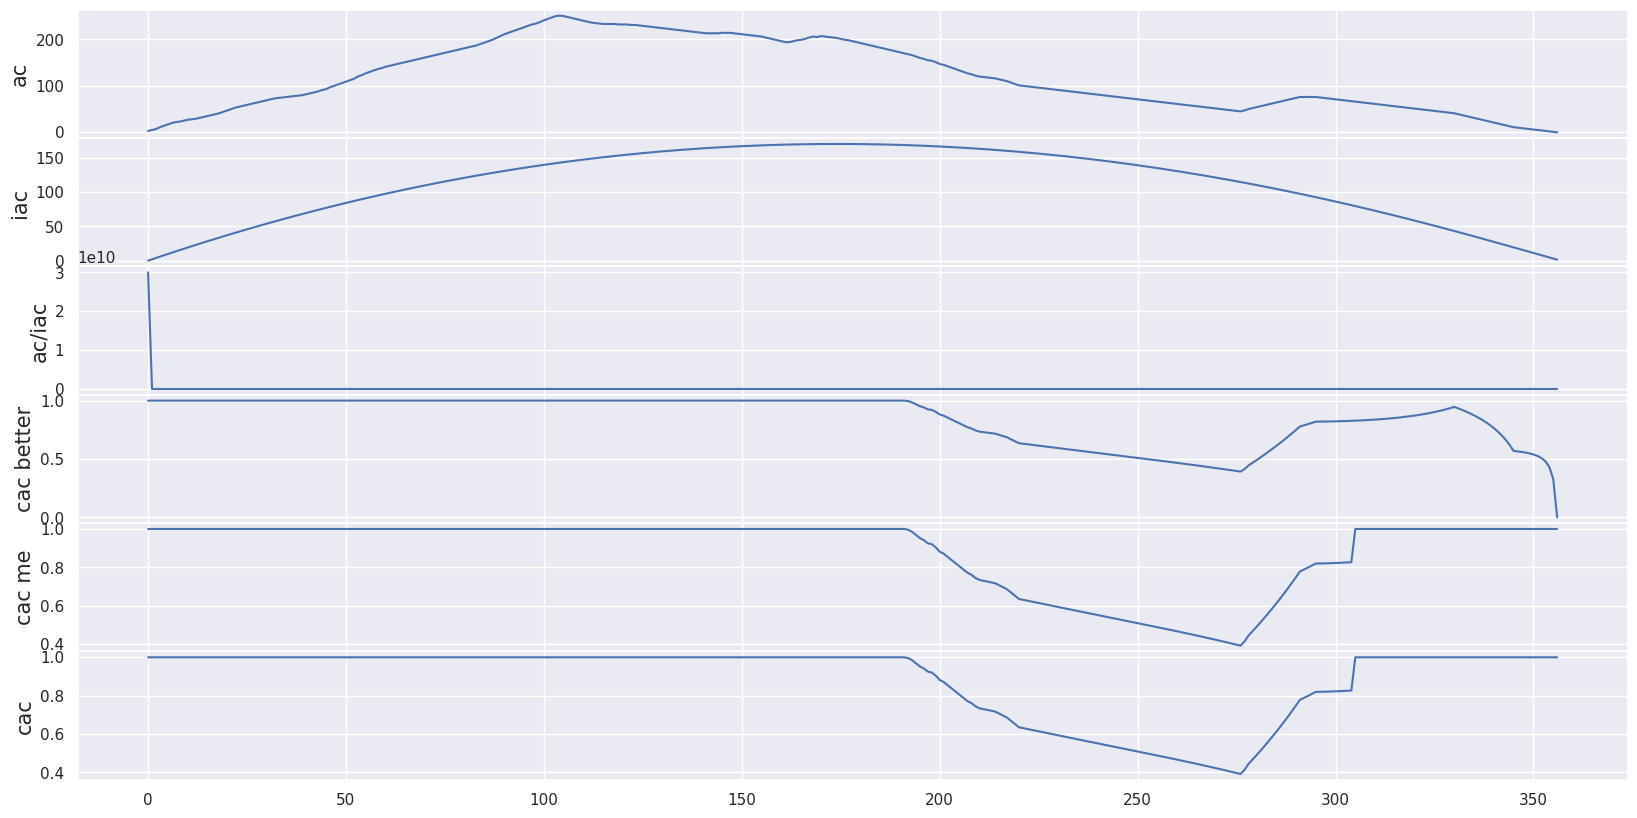

In [32]:
fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(ac)
axs[0].set_ylabel('ac', fontsize='15')

axs[1].plot(iac)
axs[1].set_ylabel('iac', fontsize='15')

axs[2].plot(cac1)
axs[2].set_ylabel('ac/iac', fontsize='15')

axs[3].plot(cac2)
axs[3].set_ylabel('cac better', fontsize='15')

axs[4].plot(cac3)
axs[4].set_ylabel('cac me', fontsize='15')

axs[5].plot(cac)
axs[5].set_ylabel('cac', fontsize='15')

## Regime location

In [33]:
regime_locations

array([276])

In [34]:
regime_locations_dates = matrix_profile_df.iloc[regime_locations]['Week Ending Date']
regime_locations_dates

276   2020-04-25
Name: Week Ending Date, dtype: datetime64[ns]

In [35]:
cac_df = pd.DataFrame(cac)
cac_df['Week Ending Date'] = wc_all.loc[0:(cac_df.shape[0]+1), 'Week Ending Date']
cac_df

,0,Week Ending Date
0,1.0,2015-01-10
1,1.0,2015-01-17
2,1.0,2015-01-24
3,1.0,2015-01-31
4,1.0,2015-02-07
...,...,...
352,1.0,2021-10-09
353,1.0,2021-10-16
354,1.0,2021-10-23
355,1.0,2021-10-30


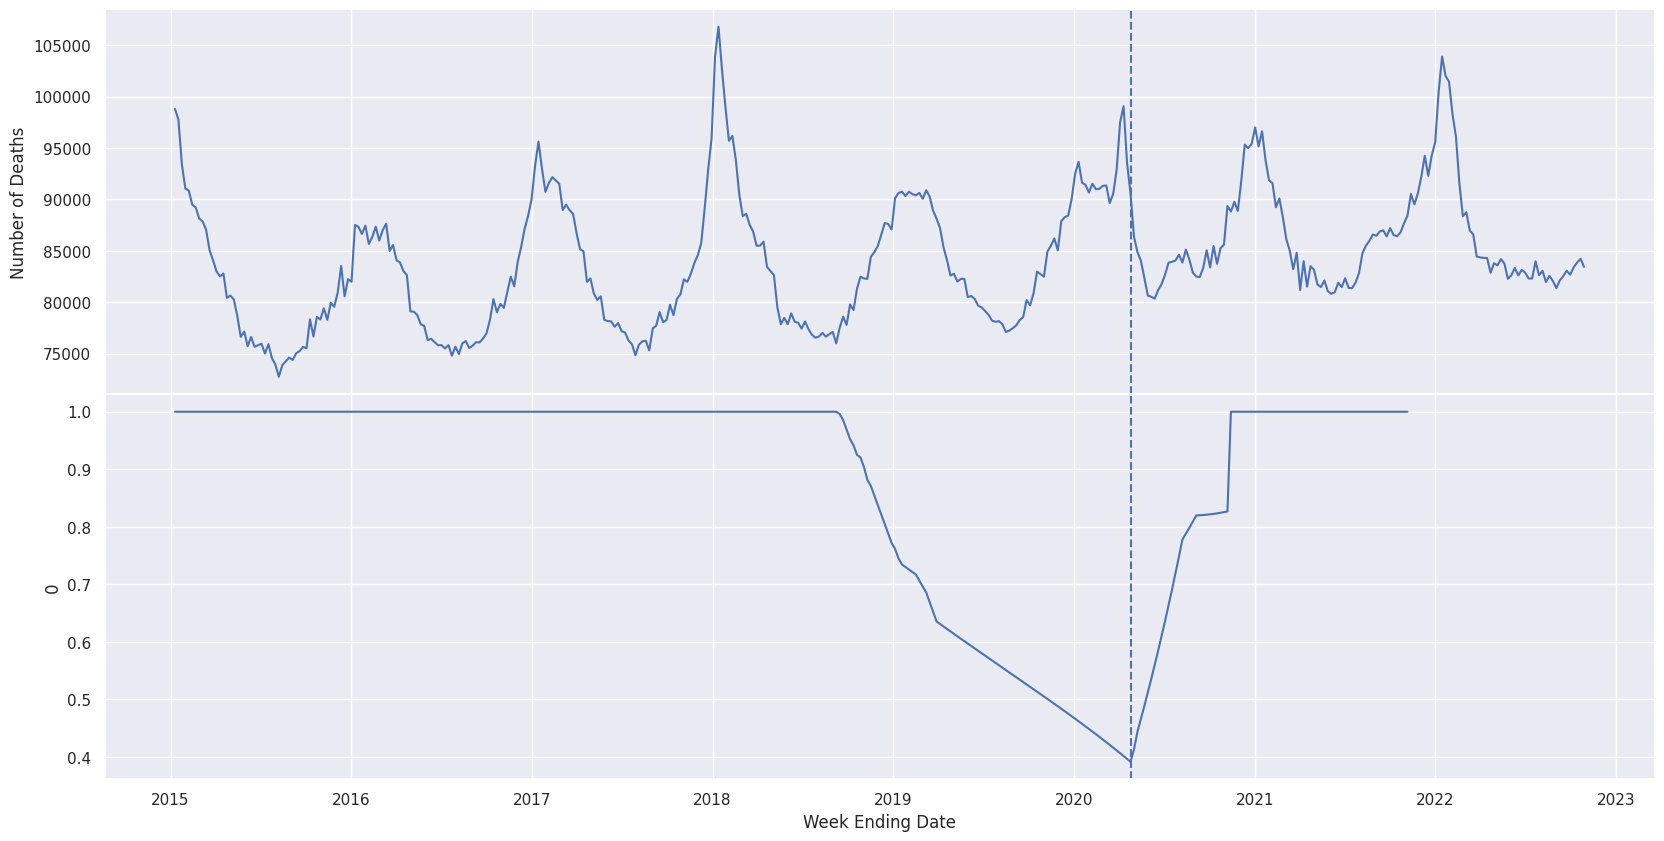

In [36]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
sns.lineplot(x='Week Ending Date', y=0, data=cac_df, ax=axs[1])

axs[0].axvline(x=regime_locations_dates.iloc[0], linestyle="dashed")
axs[1].axvline(x=regime_locations_dates.iloc[0], linestyle="dashed")
#axs[0].axvline(x=regime_locations_dates.iloc[1], linestyle="dashed")
#axs[1].axvline(x=regime_locations_dates.iloc[1], linestyle="dashed")